In [1]:
!pip install transformers --quiet
!pip install opendatasets --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Dheeraj_139
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 775MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [3]:
device ='cuda' if torch.cuda.is_available() else "cpu"
print("Available Device: ",device)

Available Device:  cuda


In [4]:
data_df=pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(["article_link"], inplace=True, axis=1)
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
X_train, X_test, y_train,y_test=train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test,y_val,y_test=train_test_split(X_test, y_test, test_size=0.5)

print("Training Size: ", X_train.shape[0], " rows which is: ", round(X_train.shape[0]/data_df.shape[0],4)*100,"%")
print("Validation Size: ", X_val.shape[0], " rows which is: ", round(X_val.shape[0]/data_df.shape[0],4)*100,"%")
print("Testing Size: ", X_test.shape[0], "  rows which is: ", round(X_test.shape[0]/data_df.shape[0],4)*100,"%")

Training Size:  18695  rows which is:  70.0 %
Validation Size:  4006  rows which is:  15.0 %
Testing Size:  4007   rows which is:  15.0 %


In [6]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X=[tokenizer(x,max_length=100,truncation=True, padding ="max_length",return_tensors='pt').to(device)
    for x in X]
    self.Y=torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)
  def __getitem__(self,indx):
    return self.X[indx],self.Y[indx]

training_data=dataset(X_train, y_train)
validation_data=dataset(X_val, y_val)
testing_data=dataset(X_test, y_test)

In [8]:
BATCH_SIZE=32
EPOCHS=10
LR=1e-4

In [9]:
train_dataloader=DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader=DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
class MyModel(nn.Module):
  def __init__(self,bert):
    super(MyModel, self).__init__()

    self.bert=bert
    self.dropout=nn.Dropout(0.25)
    self.linear1=nn.Linear(768,384)
    self.linear2=nn.Linear(384,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,input_ids,attention_mask):
    pooled_output=self.bert(input_ids, attention_mask,return_dict=False)[0][:,0]
    output=self.linear1(pooled_output)
    output=self.dropout(output)
    output=self.linear2(output)
    output=self.sigmoid(output)
    return output

In [11]:
for param in bert_model.parameters():
  param.requires_grad=False
model=MyModel(bert_model).to(device)

In [12]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [13]:
criterion=nn.BCELoss()
optimizer=Adam(model.parameters(),lr=LR)

In [21]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0
  for indx,data in enumerate(train_dataloader):
    inputs,labels=data
    inputs = {k: v.to(device) for k, v in inputs.items()}
    labels = labels.to(device)


    prediction=model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
    batch_loss=criterion(prediction,labels)
    total_loss_train+=batch_loss.item()

    acc=(prediction.round()==labels).sum().item()

    total_acc_train+=acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for indx,data in enumerate(validation_dataloader):
      inputs,labels=data
      inputs.to(device)
      labels.to(device)

      prediction=model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
      batch_loss=criterion(prediction,labels)
      total_loss_val+=batch_loss.item()

      acc=(prediction.round()==labels).sum().item()

      total_acc_val+=acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100,4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100,4))
  print(f"""
     Epoch No. {epoch+1} Train loss: {round(total_loss_train/1000,4)} Train Accuracy: {round(total_acc_train/training_data.__len__() * 100,4)}
      Validation loss: {round(total_loss_val/1000,4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100,4)}
     """)


     Epoch No. 1 Train loss: 0.1733 Train Accuracy: 87.3442
      Validation loss: 0.0396 Validation Accuracy: 86.2706
     

     Epoch No. 2 Train loss: 0.1739 Train Accuracy: 87.371
      Validation loss: 0.0401 Validation Accuracy: 86.3205
     

     Epoch No. 3 Train loss: 0.1735 Train Accuracy: 87.3496
      Validation loss: 0.0392 Validation Accuracy: 86.5701
     

     Epoch No. 4 Train loss: 0.1725 Train Accuracy: 87.5528
      Validation loss: 0.0396 Validation Accuracy: 86.1458
     

     Epoch No. 5 Train loss: 0.1732 Train Accuracy: 87.1998
      Validation loss: 0.0395 Validation Accuracy: 86.5701
     

     Epoch No. 6 Train loss: 0.1727 Train Accuracy: 87.4351
      Validation loss: 0.0389 Validation Accuracy: 86.5951
     

     Epoch No. 7 Train loss: 0.1726 Train Accuracy: 87.4726
      Validation loss: 0.0398 Validation Accuracy: 86.1957
     

     Epoch No. 8 Train loss: 0.1732 Train Accuracy: 87.4833
      Validation loss: 0.0401 Validation Accuracy: 86.8447

In [22]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0

  for indx,data in enumerate(test_dataloader):
    inputs,labels=data
    inputs.to(device)
    labels.to(device)

    prediction=model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
    batch_loss =criterion (prediction,labels)
    total_loss_test+=batch_loss.item()

    acc=(prediction.round()==labels).sum().item()
    total_acc_test+=acc

print(f"Accuracy Score on testing Data is: {round(total_acc_test/len(testing_data)*100,4)}")


Accuracy Score on testing Data is: 86.873


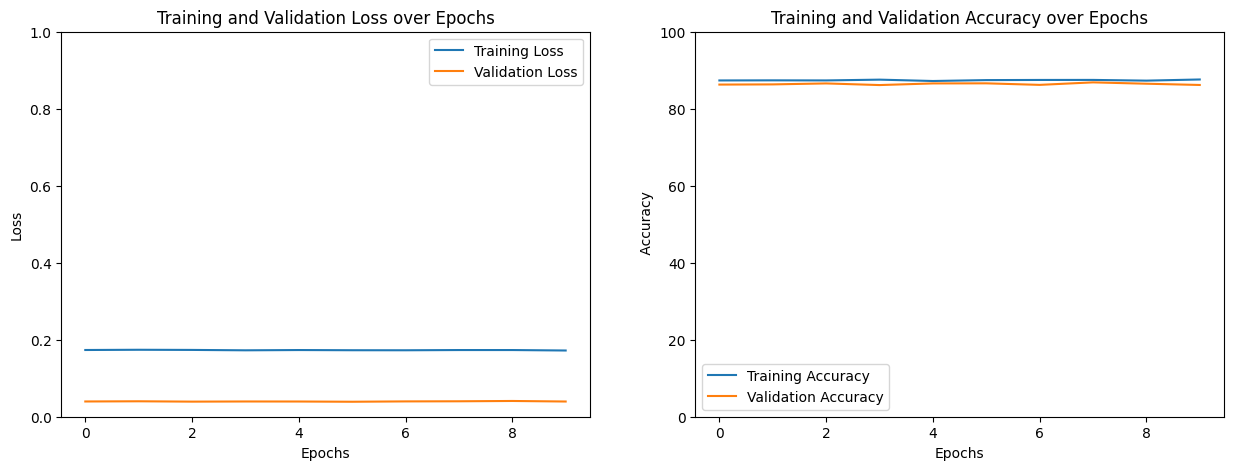

In [24]:
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label='Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_validation_plot,label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel(' Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()